In [1]:
using Plots
using LinearAlgebra
using Revise
using NeuralVerification
using NeuralVerification:Network, Layer, ReLU, Id, read_nnet, compute_output
using LazySets
using JuMP
using Ipopt
using Statistics
using Random

┌ Info: Precompiling NeuralVerification [146f25fa-00e7-11e9-3ae5-fdbac6e12fa7]
└ @ Base loading.jl:1278
┌ Warning: Package NeuralVerification does not have CPLEX in its dependencies:
│ - If you have NeuralVerification checked out for development and have
│   added CPLEX as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with NeuralVerification
└ Loading CPLEX into NeuralVerification from project dependency, future warnings for NeuralVerification are suppressed.


In [2]:
include("unicycle_env.jl")
include("problem.jl")
include("controller.jl")
include("safe_set.jl")

grad_phi (generic function with 2 methods)

In [3]:
function tracking(tp::TP, ctrl; verbose=false, only_one_step=false)
    x = tp.x0
    X = [copy(tp.x0) for k = 1:tp.T]
    U = [zeros(2) for k = 1:tp.T-1]
    safe_sets = []
    tot_time = 0
    for i in 1:tp.T-1
        if only_one_step
            x = tp.Xref[i]
        end
        xref = tp.Xref[i+1]
        timed_result = @timed get_control(ctrl, xref, x, tp.net, tp.obj_cost, tp.dt)
        u, safe_set = timed_result.value
        push!(safe_sets, safe_set)
        tot_time += timed_result.time
        x = forward(tp.net, x, u, tp.dt)
        X[i+1] = x
        U[i] = u
        cost = sum(abs.(x - xref).*tp.obj_cost)
        if verbose
            @show xref-x
            @show cost
        end
    end
    tot_error = sum(costs(tp,X))
    if verbose
        @show tot_time
        @show tot_error
    end
    return X, U, tot_time
end

function tracking_stat(net, obj_cost, tf, Xrefs, ctrl; verbose=false, only_one_step=false)
    all_costs = []
    tot_time = 0
    for i = 1:length(Xrefs)
        Xref = Xrefs[i]
        tp = TP(net, obj_cost, tf, Xref);
        Xtrack, Utrack, time = tracking(tp, ctrl, verbose=false, only_one_step=only_one_step)
        all_costs = [all_costs; costs(tp, Xtrack)]
        tot_time += time
        mean_cost = mean(costs(tp, Xtrack))
        std_cost = std(costs(tp, Xtrack))
        if verbose
            @show mean_cost, std_cost, time
        end
    end
    mean_cost = mean(all_costs)
    std_cost = std(all_costs)
    return mean_cost, std_cost, tot_time
end

tracking_stat (generic function with 1 method)

In [4]:
function nn_dynamics_tracking_state(net_path, tf, T, num; only_one_step=false, plot_traj=false, only_MIND=false, verbose=false)
    net = read_nnet(net_path);
    obj_cost = [1,1,10,10];
    Random.seed!(127);

    Xrefs, Urefs = generate_random_traj(net, num, tf, T);
    if plot_traj
        p = plot()
        for k = 1:length(Xrefs)
            xs = [Xrefs[k][i][1] for i in 1:length(Xrefs[k])]
            ys = [Xrefs[k][i][2] for i in 1:length(Xrefs[k])]
            plot!(xs, ys, legend = false)
        end
        display(p)
    end
    
    
    err_bound = [1, 1, 0.1, 0.1]
    nv_ctrl = NvController(err_bound, warm_start=true, bin_precision=2)
    nl_ctrl = NlController(err_bound, warm_start=false)
    shoot_1000 = ShootingController(1000);
    shoot_10000 = ShootingController(10000);
    shoot_100000 = ShootingController(100000);
    ctrl_names = ["MIND", "shoot_1000", "shoot_10000", "shoot_100000", "nl_ctrl"]
    ctrls = [nv_ctrl, shoot_1000, shoot_10000, shoot_100000, nl_ctrl]
    if only_MIND
        ctrl_names = ["MIND"]
        ctrls = [nv_ctrl]
    end

    mean_costs = []
    std_costs = []
    avg_times = []
    for i in 1:length(ctrls)
        name = ctrl_names[i]
        ctrl = ctrls[i]
        mean_cost, std_cost, tot_time = tracking_stat(net, obj_cost, tf, Xrefs, ctrl, only_one_step=only_one_step)
        avg_time = tot_time/(tf * T * num)
        if verbose
            @show name, mean_cost, std_cost, avg_time
        end
        push!(mean_costs, mean_cost)
        push!(std_costs, std_cost)
        push!(avg_times, avg_time)
    end
    return mean_costs, std_costs, avg_times
end

nn_dynamics_tracking_state (generic function with 1 method)

In [5]:
function get_input_samples()
    nx = 11
    ny = 11
    nv = 11
    nt = 11
    nu = 11
    xs = range(-5,stop=5,length=nx)
    ys = range(-5,stop=5,length=ny)
    vs = range(-2,stop=2,length=nv)
    θs = range(-π,stop=π,length=nt)
    u1s = range(-4,stop=4,length=nu)
    u2s = range(-π,stop=π,length=nu)
    samples = [[x,y,v,θ, u1, u2] for x in xs, y in ys, v in vs, θ in θs, u1 in u1s, u2 in u2s];
    return samples
end
input_samples = get_input_samples();

In [6]:
function model_mismatch(net_path, input_samples)
    net = read_nnet(net_path);
    errors = []
    gts = []
    nts = []
    for input in input_samples
        gt_dot_x = traj_rk4(input[1:4], input[5:6], 0.1)
        net_dot_x = compute_output(net, input)
        push!(gts, gt_dot_x)
        push!(nts, net_dot_x)
    end
    return gts, nts
end

model_mismatch (generic function with 1 method)

In [7]:
function tracking_stat(layers, hidden, tf, T, num, only_MIND; only_modeling_error=false)
    @assert length(layers) == length(hidden)
    mmes = []
    ats = []
    for i in 1:length(layers)
        net_path = "../nnet/unicycle-FC"*string(layers[i])*"-"*string(hidden[i])*"-rk4-extra/epoch_1000.nnet"
        gts, nts = model_mismatch(net_path, input_samples)
        a = norm.(gts-nts)
        mean_modeling_error = mean(a)
        @show  layers[i], hidden[i], mean_modeling_error
        only_modeling_error && continue
        mean_costs, std_costs, avg_times = nn_dynamics_tracking_state(net_path, tf, T, num; only_MIND=only_MIND, verbose=true)
    end
    return mmes, ats
end

tracking_stat (generic function with 2 methods)

In [ ]:
# Generalizability of MIND to different network size.
layers = [2, 2, 2, 2, 2]
hidden = [50, 100, 200, 300, 500]
tracking_stat(layers, hidden, 1, 10, 5, true)

(layers[i], hidden[i], mean_modeling_error) = (2, 50, 0.27552893186844896)
(name, mean_cost, std_cost, avg_time) = ("MIND", 9.594550124253365e-9, 1.83212461574977e-8, 0.033666931340000004)
(layers[i], hidden[i], mean_modeling_error) = (2, 100, 0.19887079441090091)
(name, mean_cost, std_cost, avg_time) = ("MIND", 9.531502894463348e-5, 0.0005306145943204558, 0.09881693136000001)
(layers[i], hidden[i], mean_modeling_error) = (2, 200, 0.1881726030392792)
(name, mean_cost, std_cost, avg_time) = ("MIND", 7.86308247141064e-5, 0.000525182482589403, 0.29488581048)
(layers[i], hidden[i], mean_modeling_error) = (2, 300, 0.1906573321926879)
(name, mean_cost, std_cost, avg_time) = ("MIND", 0.00014161719855211452, 0.0007240095032253106, 0.69640432226)


In [10]:
layers = [3, 3]
hidden = [50, 100]
tracking_stat(layers, hidden, 1, 10, 5, true)

(layers[i], hidden[i], mean_modeling_error) = (3, 50, 0.1509922031045889)
(name, mean_cost, std_cost, avg_time) = ("MIND", 2.3645730751198357e-9, 5.5599946988697816e-9, 0.3406784541)
(layers[i], hidden[i], mean_modeling_error) = (3, 100, 0.13868215768549233)
(name, mean_cost, std_cost, avg_time) = ("MIND", 9.544576000178467e-5, 0.0005393960069612929, 1.65434910236)


In [10]:
layers = [4]
hidden = [50]
tracking_stat(layers, hidden, 1, 10, 5, true)

(layers[i], hidden[i], mean_modeling_error) = (4, 50, 0.14122894529880348)
(name, mean_cost, std_cost, avg_time) = ("MIND", 4.026861891437417e-9, 7.634653365965823e-9, 0.88411118112)


In [8]:
# Generalizability of MIND to different network size.
layers = [2]
hidden = [500]
tracking_stat(layers, hidden, 1, 10, 5, true, only_modeling_error=true)

(layers[i], hidden[i], mean_modeling_error) = (2, 500, 0.1680218728690854)


(Any[], Any[])

In [9]:
# Compare different solvers with three different NNDMs.
layers = [3, 3, 4]
hidden = [50, 100, 50]
tracking_stat(layers, hidden, 1, 10, 50, false)

(layers[i], hidden[i], mean_modeling_error) = (3, 50, 0.1509922031045889)
(name, mean_cost, std_cost, avg_time) = ("MIND", 2.7328601854516227e-6, 5.77566257362756e-5, 0.48870881899999996)
(name, mean_cost, std_cost, avg_time) = ("shoot_1000", 0.13343616564152408, 0.08418422823646443, 0.005131256550000003)
(name, mean_cost, std_cost, avg_time) = ("shoot_10000", 0.04239372840681775, 0.02763579087828977, 0.04441454755199999)
(name, mean_cost, std_cost, avg_time) = ("shoot_100000", 0.012635191936223693, 0.008127789781483563, 0.44544387998199997)

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

(name, mean_cost, std_cost, avg_time) = ("nl_ctrl", 1.87161955712

(Any[], Any[])

In [53]:
function draw_tracking_compare(net_path, tf, T, num; original_ipopt=false)
    prefix = original_ipopt ? "tracking_original" : "tracking"
    net = read_nnet(net_path);
    obj_cost = [1,1,10,10];
    Random.seed!(4);

    Xrefs, Urefs = generate_random_traj(net, num, tf, T);
    # p = plot()
    # for k = 1:num
    #     xs = [Xrefs[k][i][1] for i in 1:length(Xrefs[k])]
    #     ys = [Xrefs[k][i][2] for i in 1:length(Xrefs[k])]
    #     plot!(xs, ys, legend = false)
    # end
    # display(p)

    err_bound = original_ipopt ? [1, 1, 1, 1]*100 : [1, 1, 0.1, 0.1]
    nv_ctrl = NvController(err_bound, warm_start=false, bin_precision=2)
    nl_ctrl = NlController(err_bound, warm_start=false)
    shoot_100 = ShootingController(100);
    ctrls = [nv_ctrl, shoot_100, nl_ctrl]
    labels = ["MIND", "Shooting", original_ipopt ? "Ipopt_original" : "Ipopt"]
    
    for k = 1:num
        p = k == 1 ? plot(dpi=200) : plot(legend=:none, dpi=200)
        xs = [Xrefs[k][i][1] for i in 1:length(Xrefs[k])]
        ys = [Xrefs[k][i][2] for i in 1:length(Xrefs[k])]
        plot!(xs, ys, linewidth=5, label="Reference", legendfontsize=20)
        Xtracks = []
        for (i,ctrl) in enumerate(ctrls)
            tp = TP(net, obj_cost, tf, Xrefs[k]);
            Xtrack, Utrack, time = tracking(tp, ctrl, verbose=false, only_one_step=false)
            xs = [Xtrack[j][1] for j in 1:length(Xtrack)]
            ys = [Xtrack[j][2] for j in 1:length(Xtrack)]
            plot!(xs, ys, linewidth=2, label=labels[i])
        end
        display(p)
        savefig("../results/"*prefix*"_"*string(k)*".png")
    end
end


draw_tracking_compare (generic function with 1 method)

In [65]:
function draw_tracking_compare(net_path, tf, T, num; original_ipopt=false)
    prefix = original_ipopt ? "tracking_original" : "tracking"
    net = read_nnet(net_path);
    obj_cost = [1,1,10,10];
    Random.seed!(4);

    Xrefs, Urefs = generate_random_traj(net, num, tf, T);
    # p = plot()
    # for k = 1:num
    #     xs = [Xrefs[k][i][1] for i in 1:length(Xrefs[k])]
    #     ys = [Xrefs[k][i][2] for i in 1:length(Xrefs[k])]
    #     plot!(xs, ys, legend = false)
    # end
    # display(p)
    
    err_bound = original_ipopt ? [1, 1, 1, 1]*100 : [0.1, 0.1, 0.1, 0.1]
    nv_ctrl = NvController(err_bound, warm_start=false, bin_precision=2)
    nl_ctrl = NlController(err_bound, warm_start=false)
    shoot_100 = ShootingController(100);
    ctrls = [nv_ctrl, shoot_100, nl_ctrl]
    labels = ["MIND", "Shooting", original_ipopt ? "Ipopt_original" : "Ipopt"]
    
    for k = 1:num
        if k != 1 && k != 3 && k != 4
            continue
        end
        p = k == 1 ? plot(dpi=200) : plot(legend=:none, dpi=200)
        xs = [Xrefs[k][i][1] for i in 1:length(Xrefs[k])]
        ys = [Xrefs[k][i][2] for i in 1:length(Xrefs[k])]
        plot!(xs, ys, linewidth=5, label="Reference", legendfontsize=20)
        Xtracks = []
        Utracks = []
        for (i,ctrl) in enumerate(ctrls)
            tp = TP(net, obj_cost, tf, Xrefs[k]);
            Xtrack, Utrack, time = tracking(tp, ctrl, verbose=false, only_one_step=false)
            push!(Utracks, Utrack)
            xs = [Xtrack[j][1] for j in 1:length(Xtrack)]
            ys = [Xtrack[j][2] for j in 1:length(Xtrack)]
            plot!(xs, ys, linewidth=2, label=labels[i])
        end
        display(p)
        savefig("../results/"*prefix*"_"*string(k)*".png")
        
        p1 = k == 1 ? plot(dpi=200) : plot(legend=:none, dpi=200)
        p2 = k == 1 ? plot(dpi=200) : plot(legend=:none, dpi=200)
        for i = 1:length(Utracks)
            uv = [u[1] for u in Utracks[i]]
            ua = [u[2] for u in Utracks[i]]
            plot!(p1, uv, label=labels[i], linewidth=2, legendfontsize=20)
            plot!(p2, ua, label=labels[i], linewidth=2, legendfontsize=20)
        end
        xlabel!(p1, "time step")
        xlabel!(p2, "time step")
        ylabel!(p1, "control 1")
        ylabel!(p2, "control 2")
        l = @layout [a; b]
        plot(p1, p2, layout = l, dpi=200)
        display(p1)
        display(p2)
        savefig("../results/"*prefix*"_control_"*string(k)*".png")
    end
end

draw_tracking_compare (generic function with 1 method)

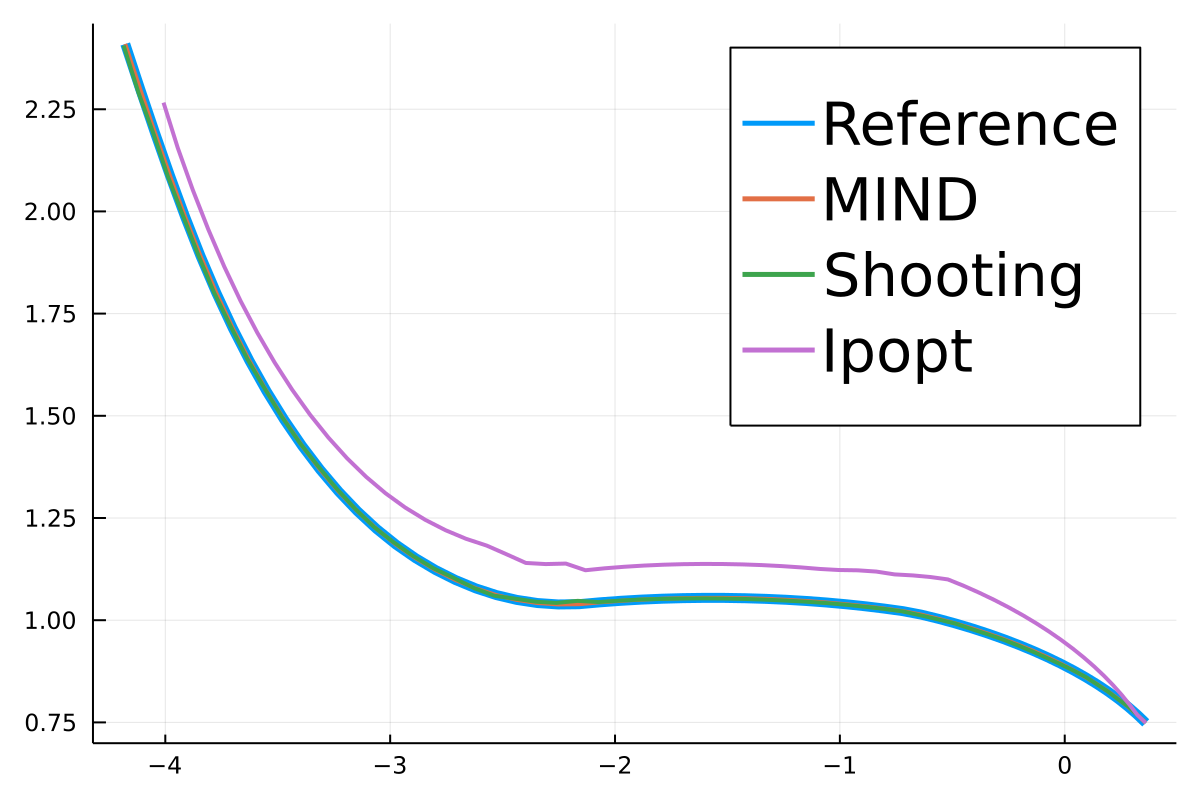

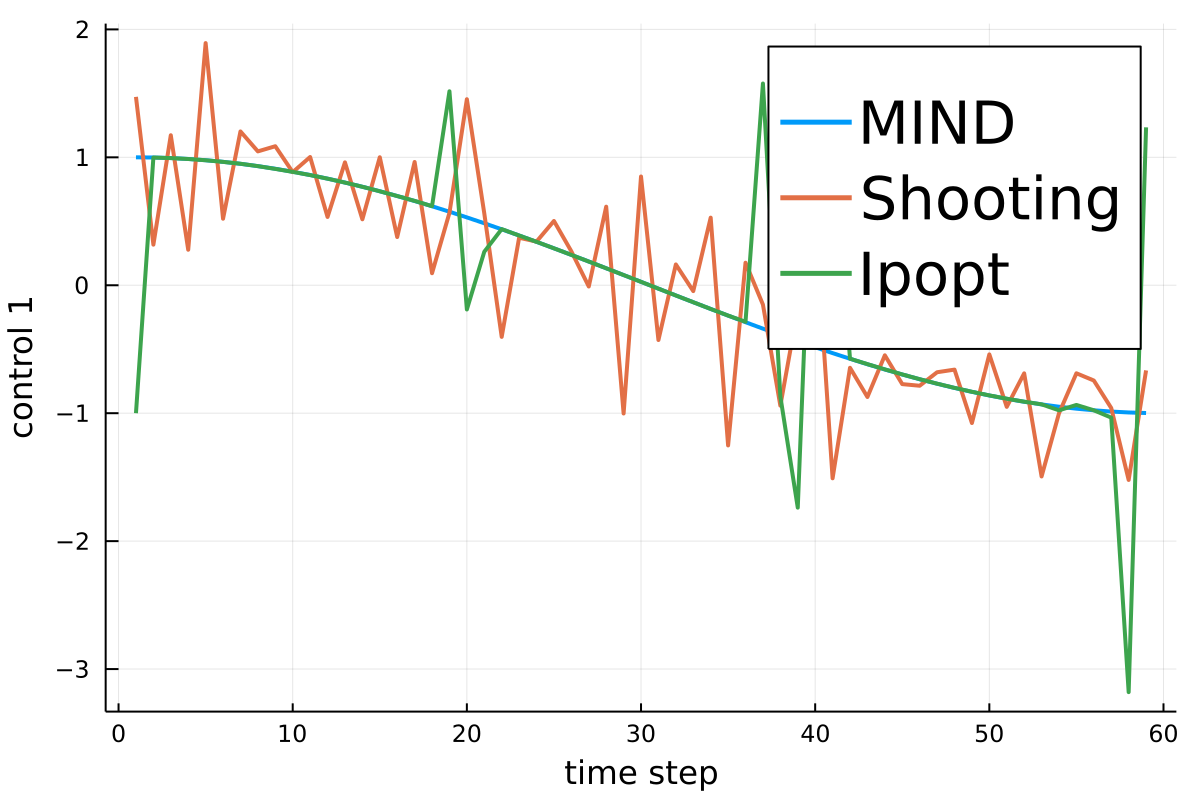

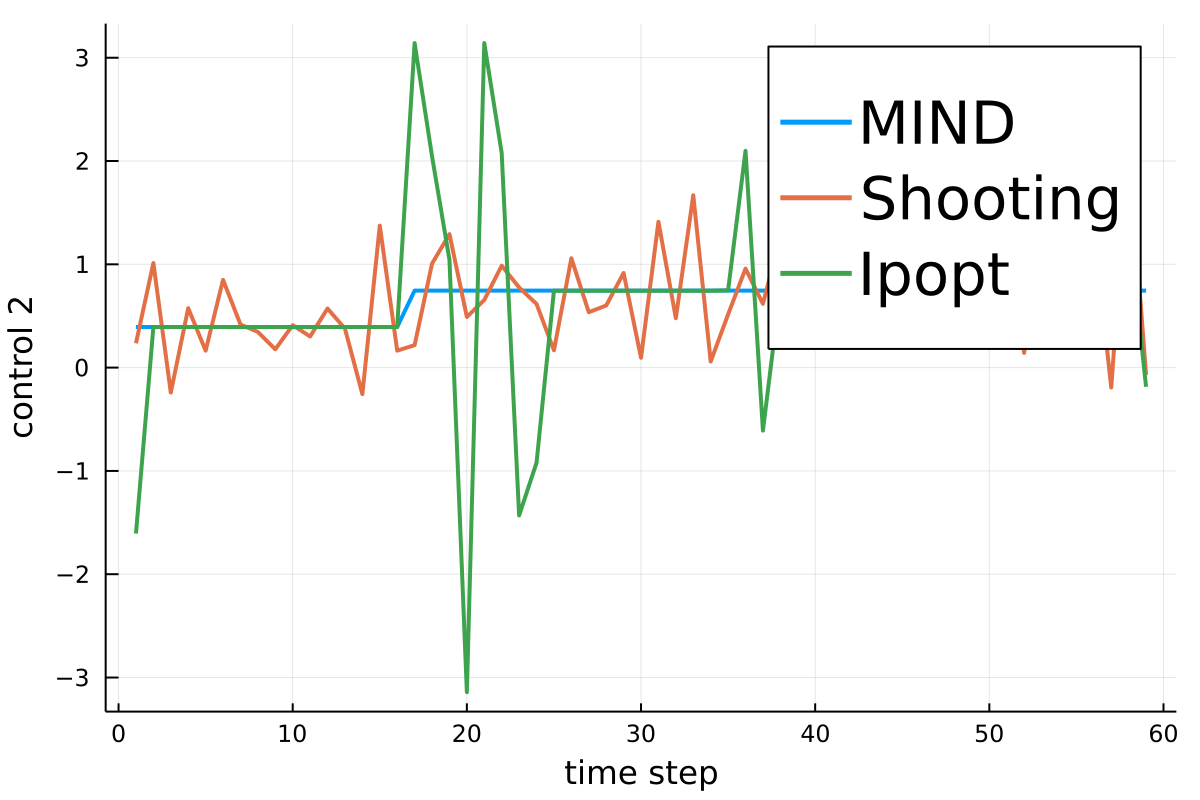

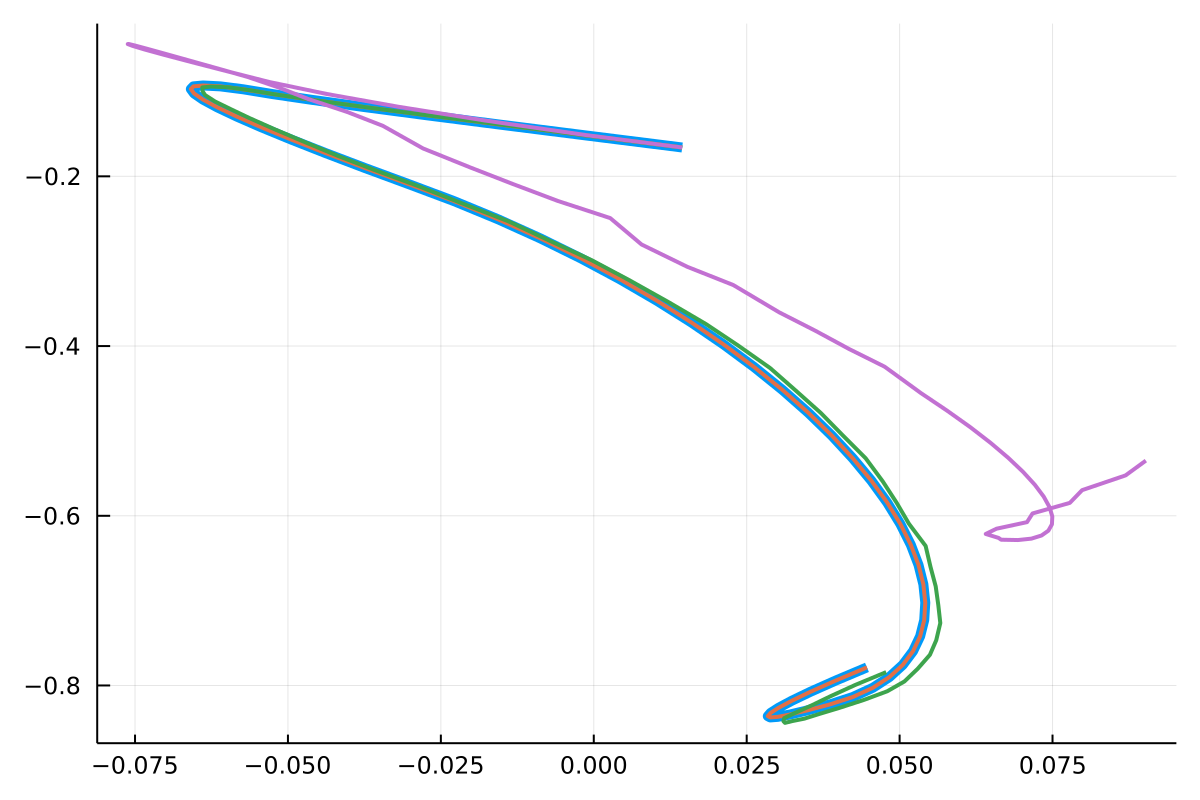

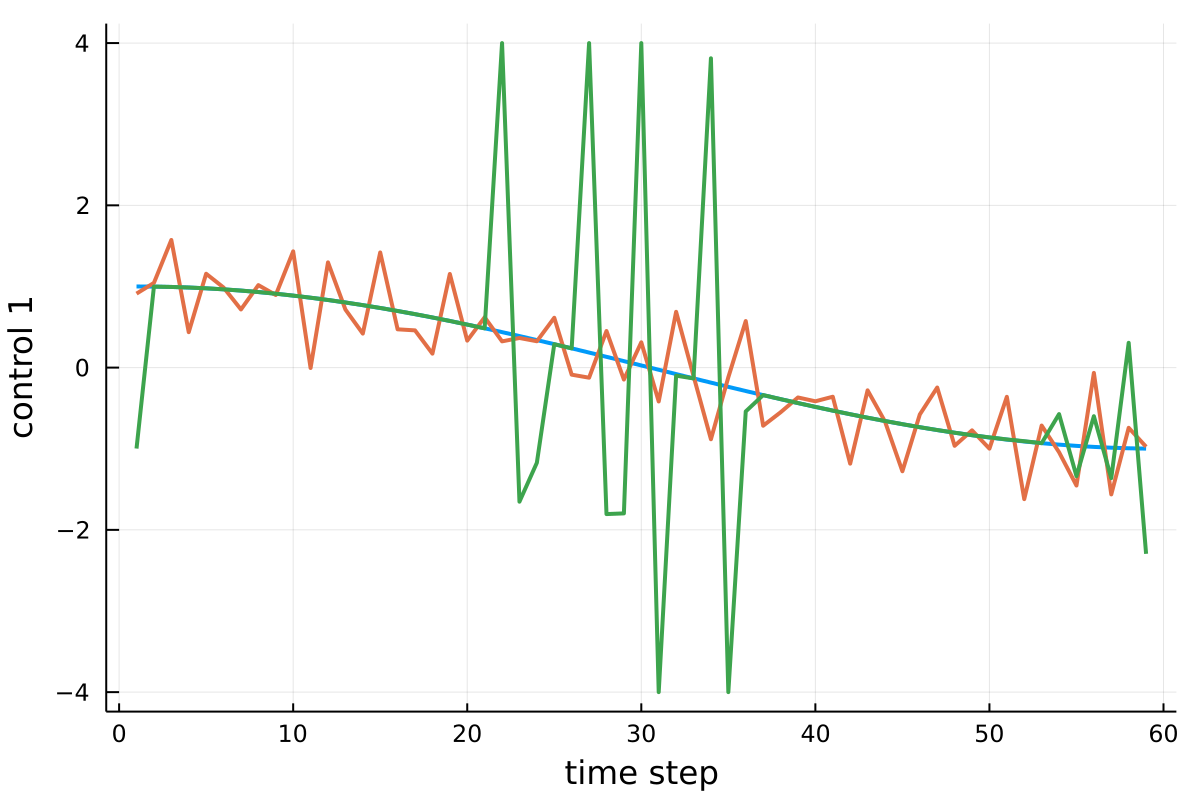

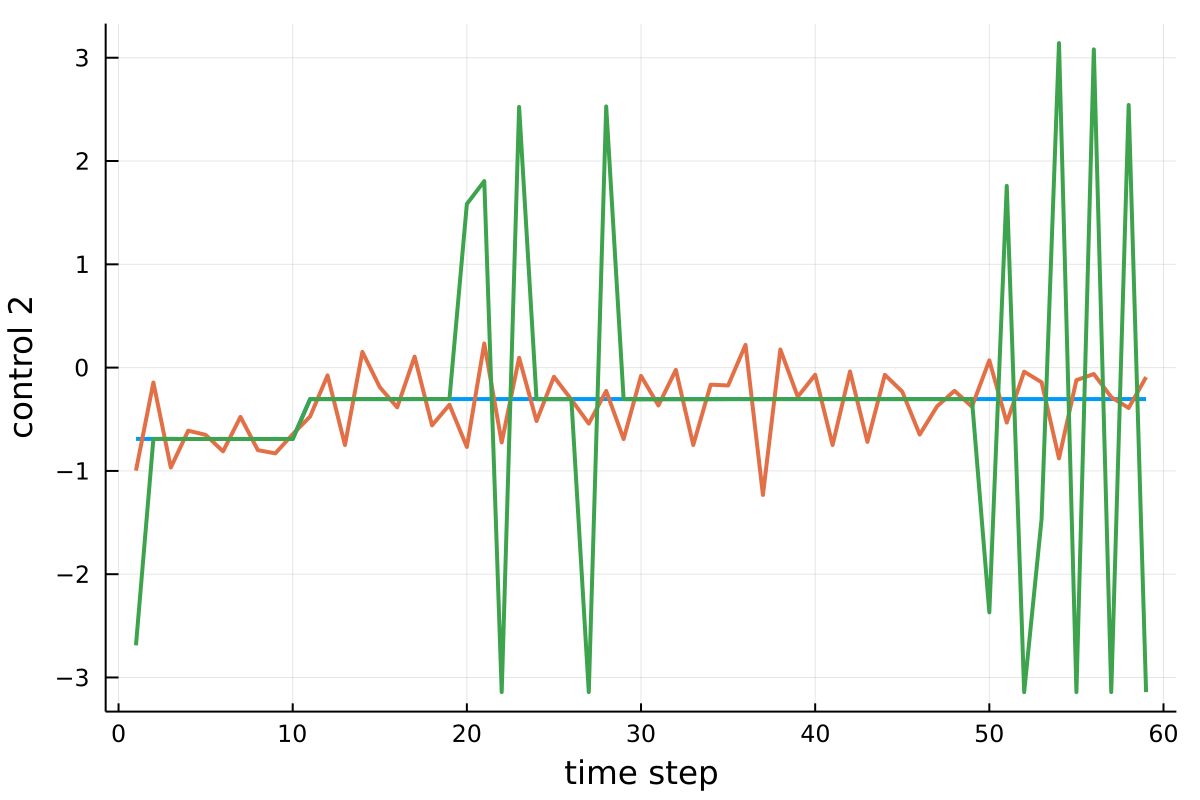

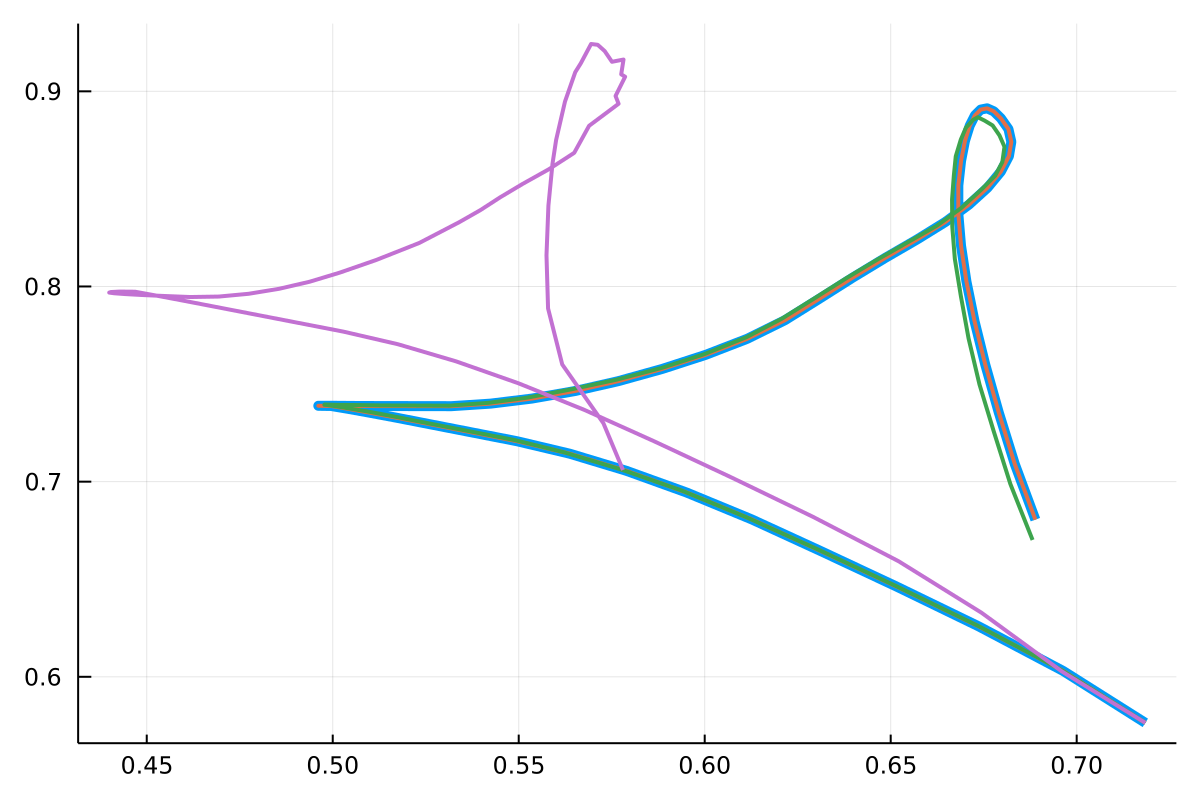

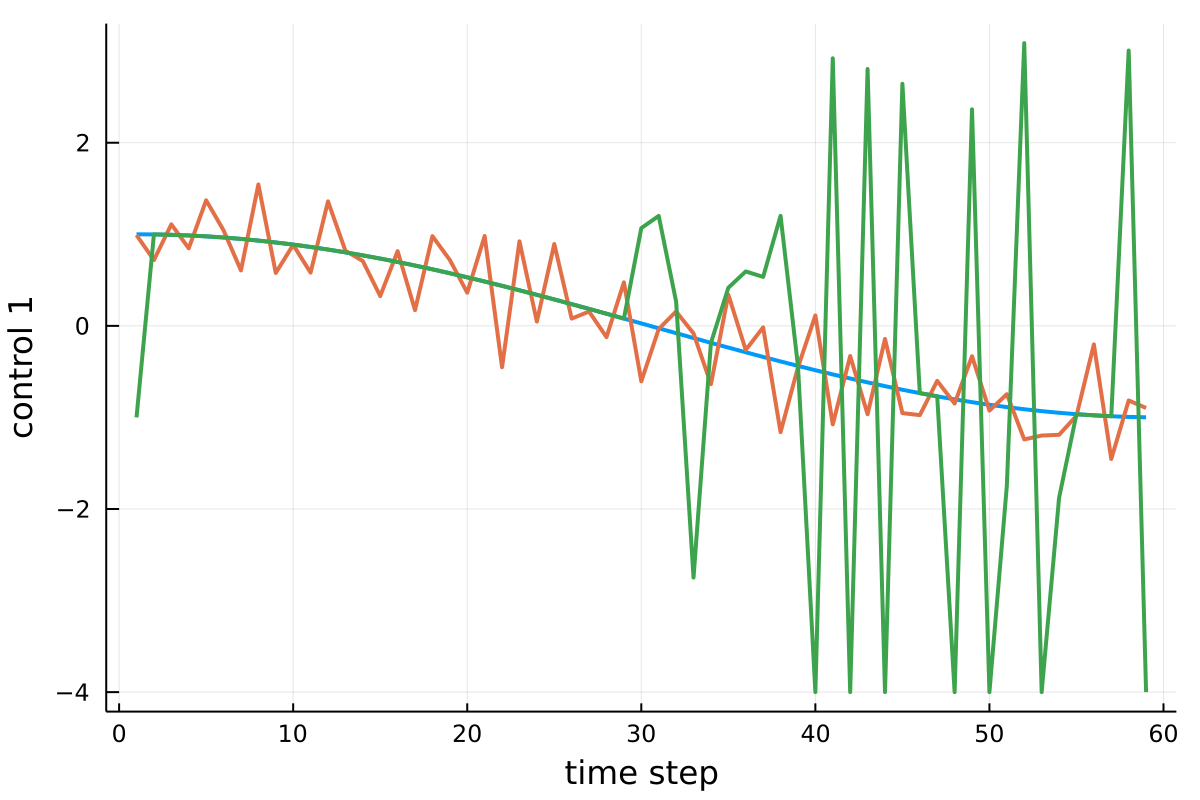

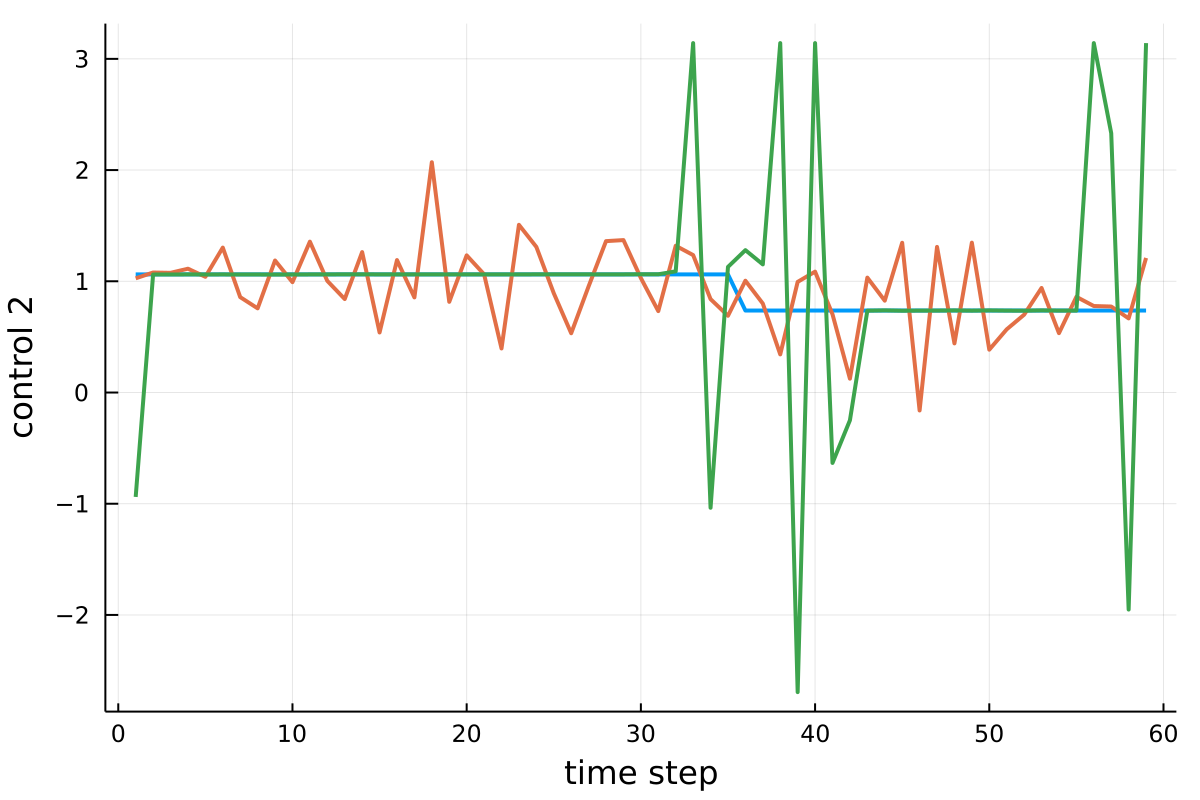

In [66]:
net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
draw_tracking_compare(net_path, 3, 60, 5; original_ipopt=false)

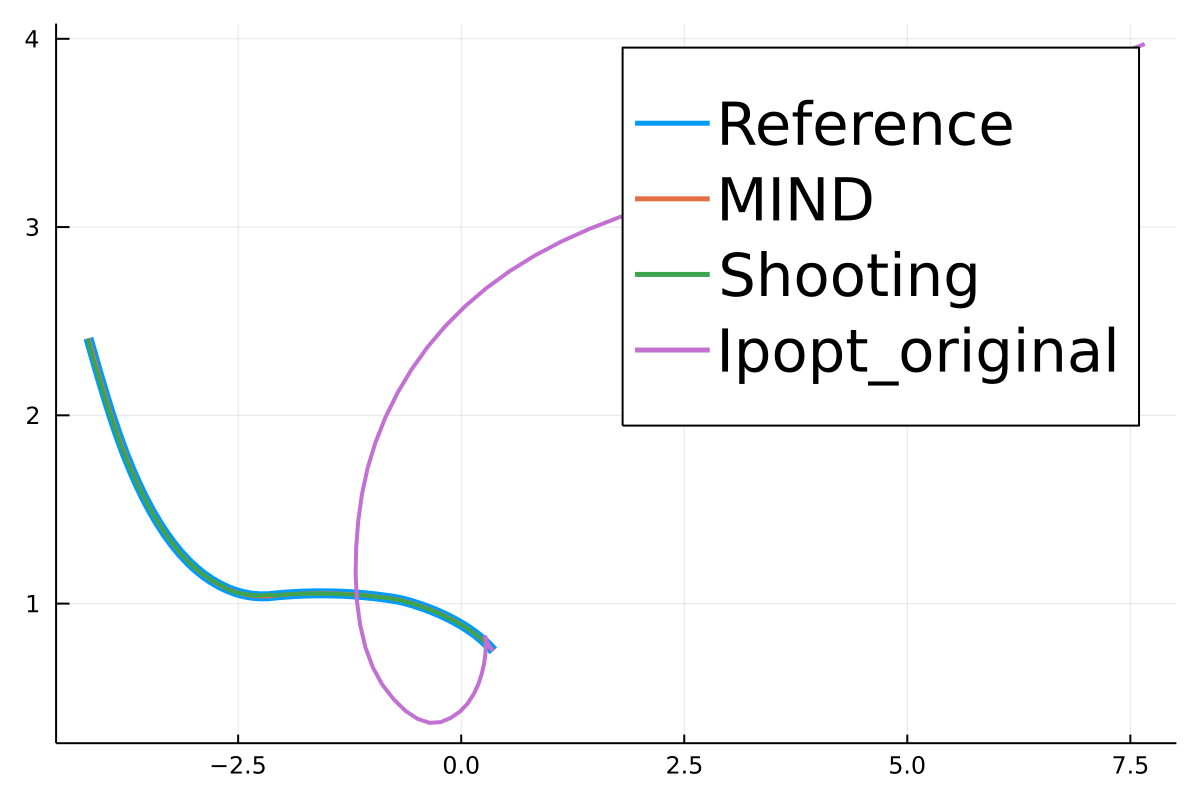

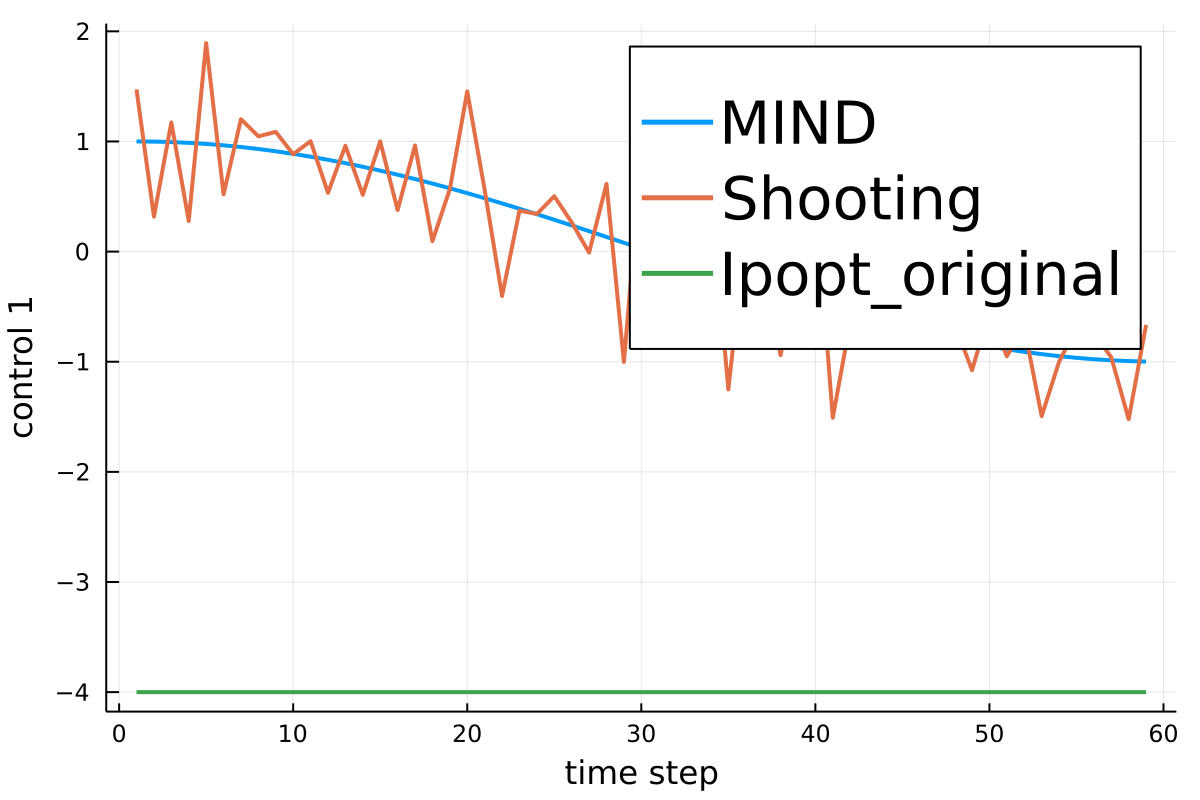

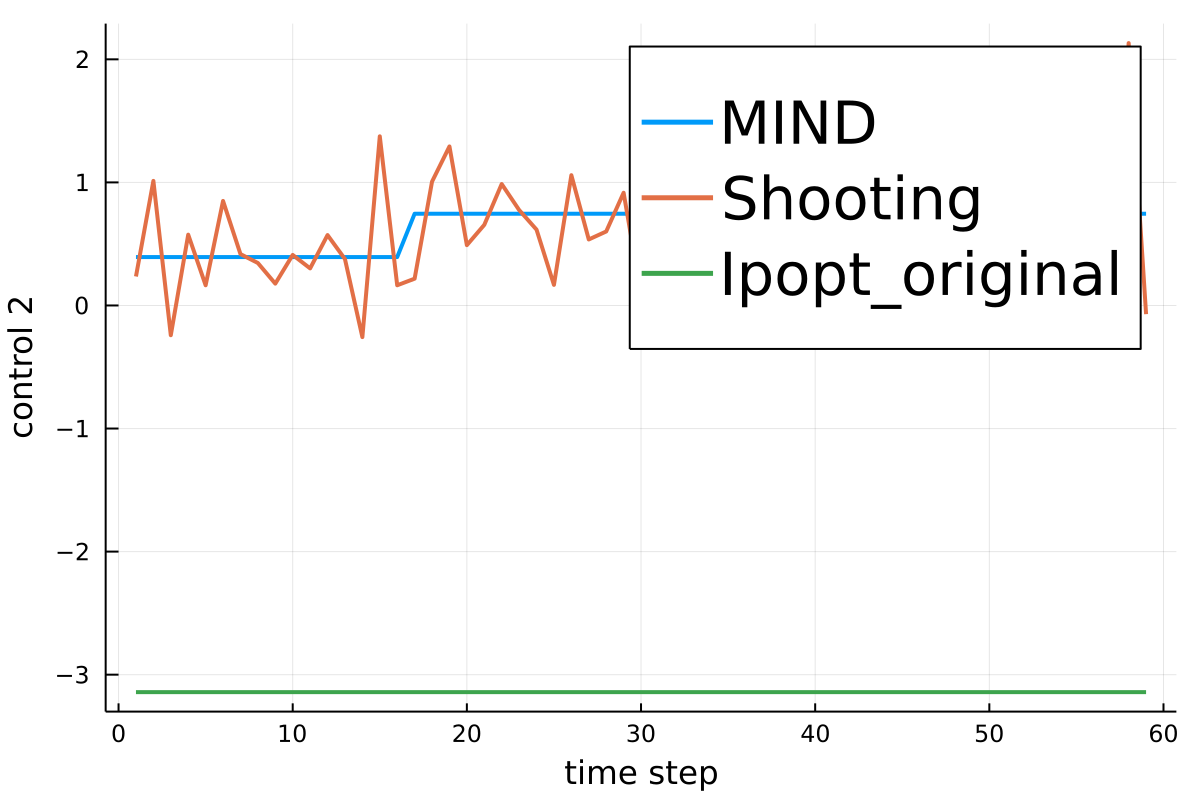

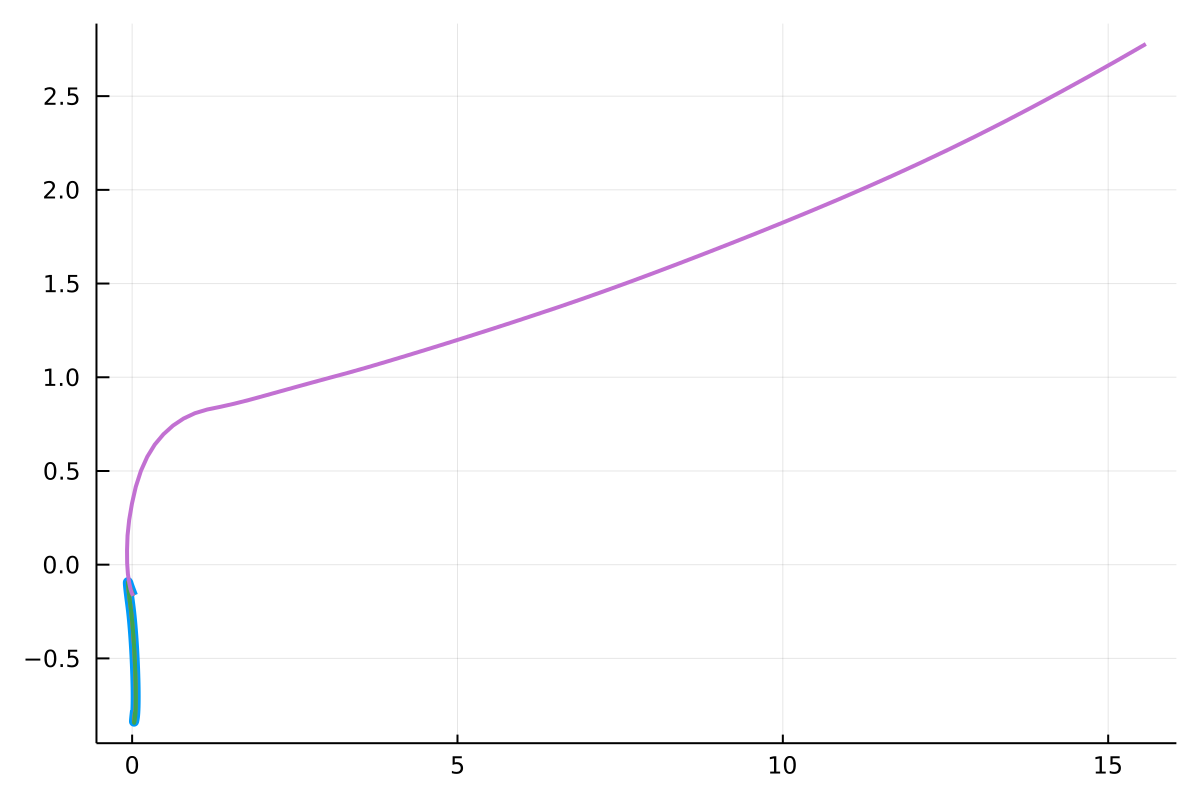

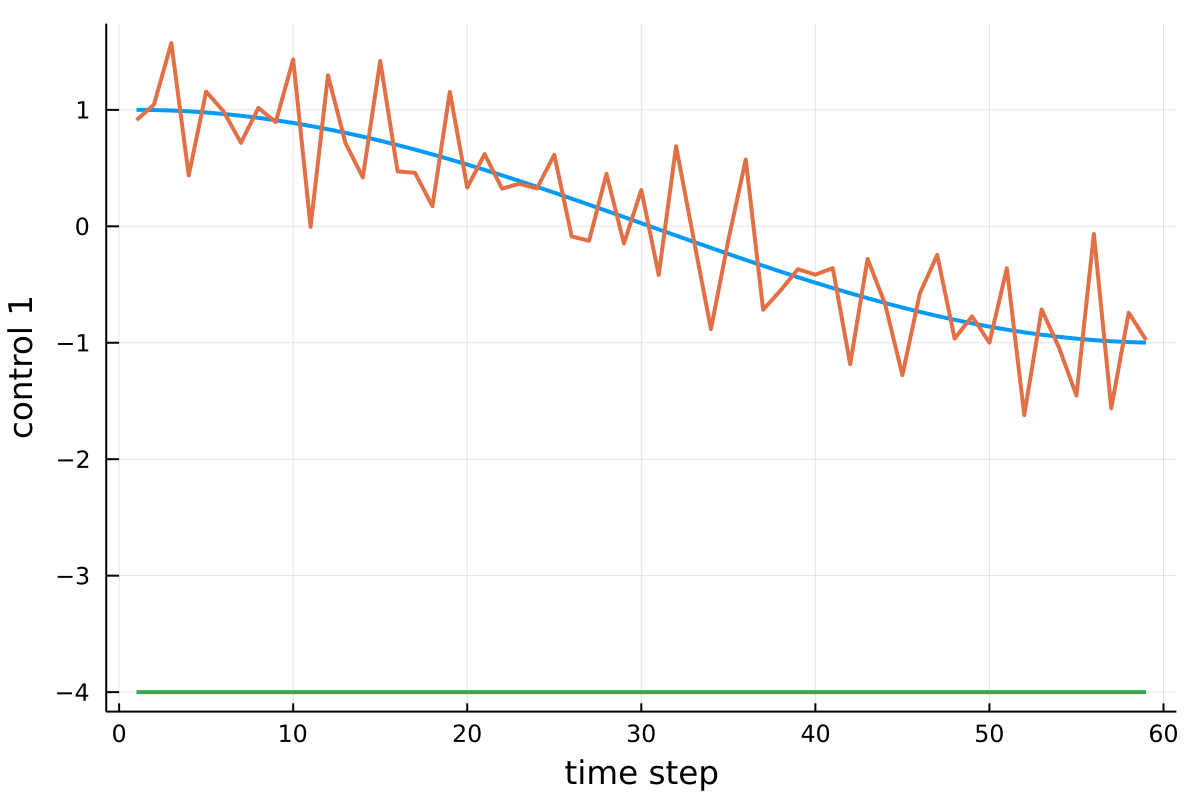

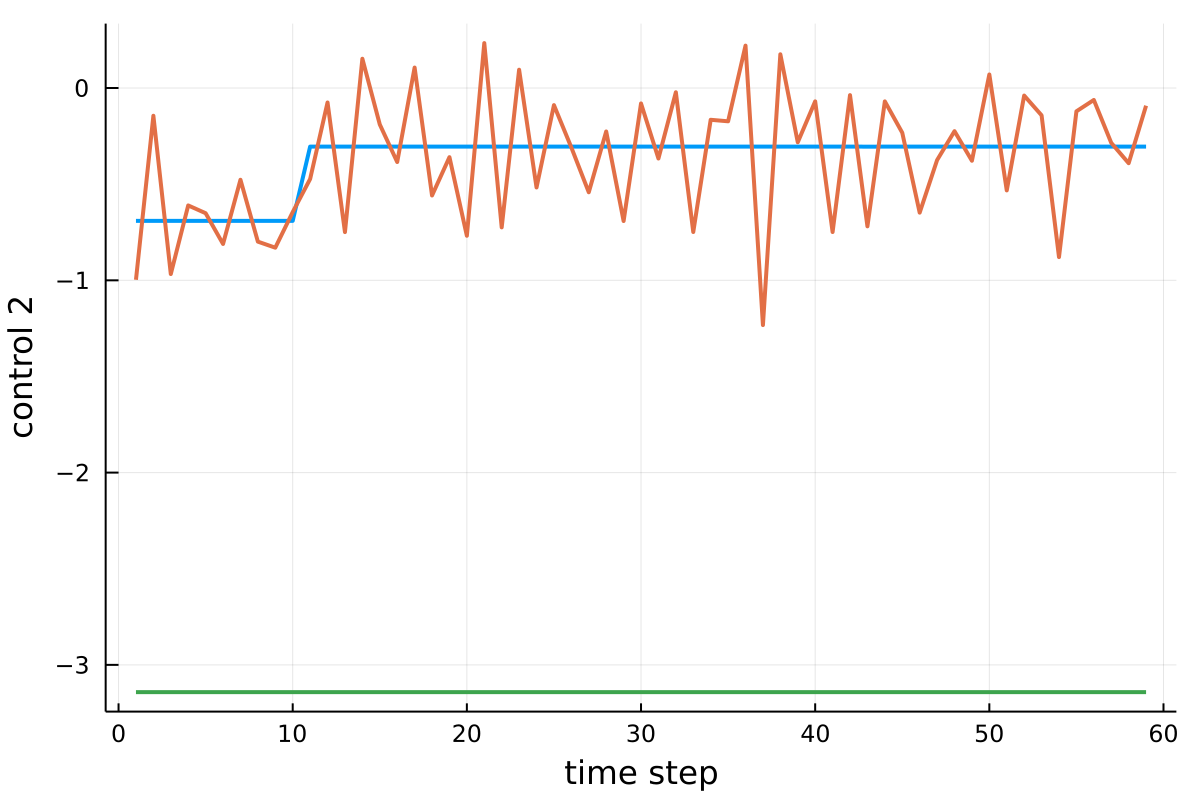

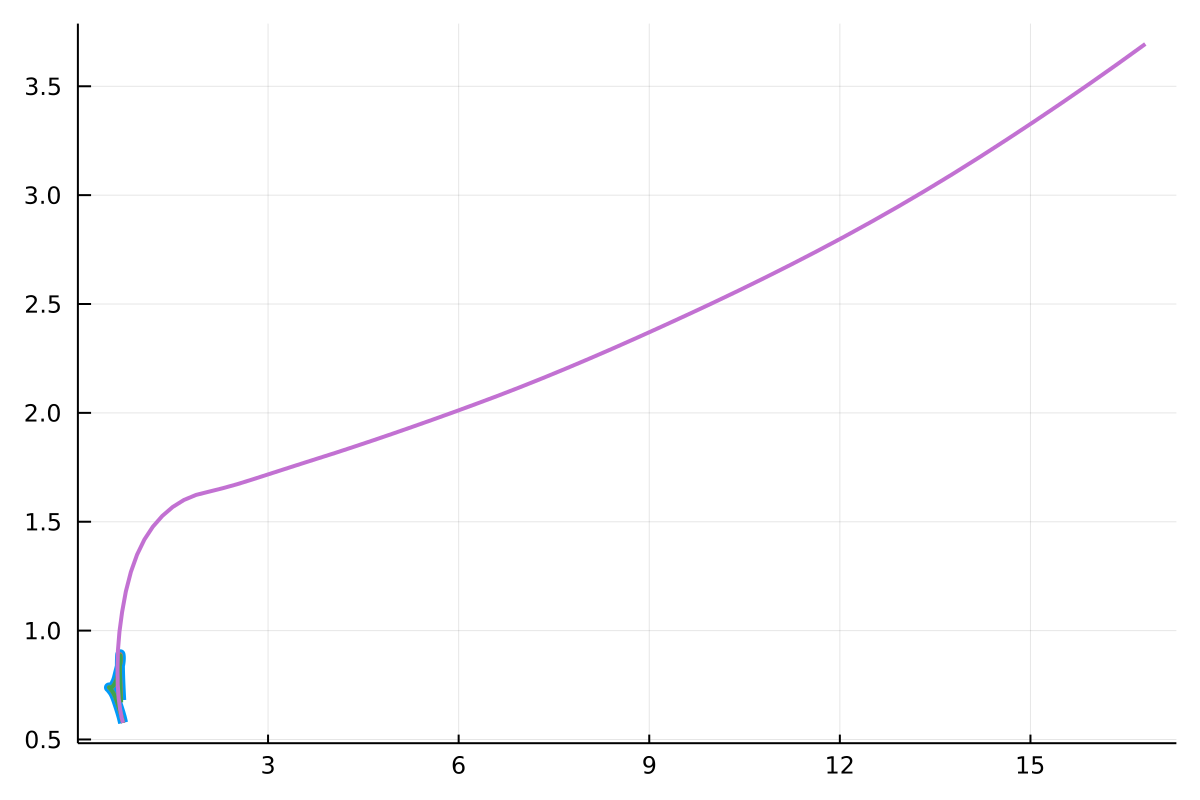

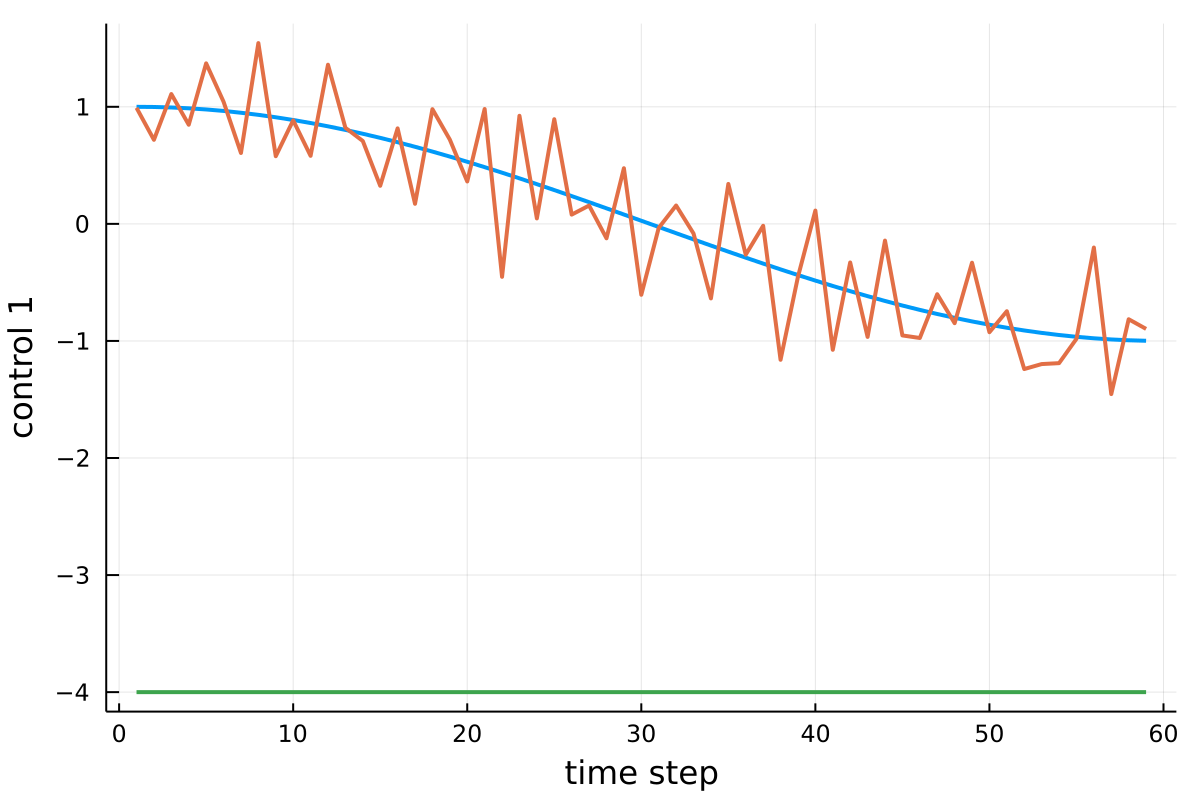

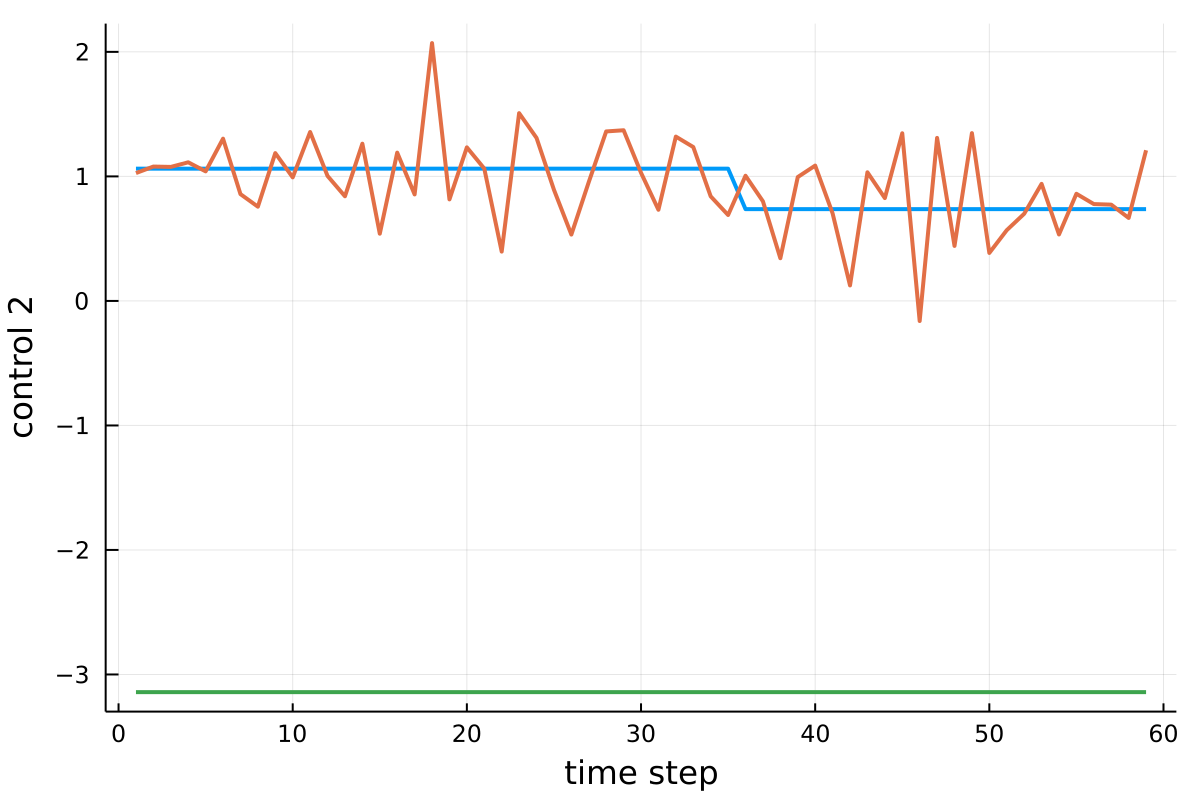

In [62]:
net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
draw_tracking_compare(net_path, 3, 60, 5; original_ipopt=true)